In [2]:
import torch.nn as nn
import sys
import os
project_root = os.path.abspath("..")  # Adjust if needed
import pytorch_lightning as pl
# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)


from src.utils.data_utils import *
from src.dataset_classes.pointDataset import *
from proteinshake.datasets import ProteinFamilyDataset
from proteinshake.tasks import LigandAffinityTask
import random
from src.models.pointVAE import pointVAE
from src.models.basicVae import LitBasicVae
from src.models.PointNetVae_chamfer_split import PointNetVAE
from torch.utils.data import Dataset, Subset
from torch_geometric.utils import to_dense_batch, to_dense_adj
import numpy as np
from src.utils.data_utils import *
from src.dataset_classes.pointDataset import *
from src.dataset_classes.sequenceDataset import *

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
point_data = ProteinFamilyDataset(root='../data').to_point().torch()
graph_data = ProteinFamilyDataset(root='../data').to_graph(eps = 8).pyg()

seq_dataset = SequenceDataset(point_data, 500, return_proteins=True)
graph_dataset = load_graph_data(graph_data)
point_dataset =  PointDataset(point_data, 500, return_proteins=True)


batch_size = 128

graph_loader = torch_geometric.loader.DataLoader(graph_dataset, batch_size = batch_size, shuffle = False)
seq_dataloader = DataLoader(seq_dataset, batch_size = batch_size, shuffle = False)
families = [k[1]['protein']['Pfam'][0] for k in seq_dataset.org_protein_data]
point_dataloader = DataLoader(point_dataset, batch_size = batch_size, shuffle = False)

100%|██████████| 31109/31109 [00:06<00:00, 5038.05it/s]


In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# Load in Graph Data, Perform inferenece with different Graph Models for Beta values and save outputs

In [5]:
beta_model_folder_path = '../trained_models/Pfam/GVAE/BETA_EXP'
beta_models_paths = os.listdir(beta_model_folder_path)
save_path = '../data/Beta_GraphData'

In [6]:
beta_models_paths

['3_LD32_HD512_Beta1_GCH16_LR0.0001.ckpt',
 '2_LD32_HD512_Beta0.1_GCH16_LR0.0001.ckpt',
 '0_LD32_HD512_Beta0.001_GCH16_LR0.0001.ckpt',
 '1_LD32_HD512_Beta0.01_GCH16_LR0.0001.ckpt']

In [ ]:
for model_path in beta_models_paths:
    model = model_path.split('.')[0]
    print(f'Running Inference on model {model}')
    beta = model_path.split('a')[-1].split('_')[0]
    graph_latent_output = []
    # Load Model
    graph_model = GraphVAE.load_from_checkpoint(beta_model_folder_path+'/'+model_path)
    graph_model.to(device)
    graph_model.eval()

    # Inference on Model
    for idx, batch in tqdm(enumerate(graph_loader)):
        rep_z, x_mu, x_logvar, x_rec, logit_feature, adj_matrix = graph_model(batch.to(device))
        graph_latent_output.append(x_mu.detach().cpu().numpy())

    # Save values in numpy array for later use
    graph_latent_output = np.concatenate(graph_latent_output, axis = 0)
    np.save(save_path+'/'+f'Graph_Beta_{beta_increment_val}.npy', graph_latent_output)
    print(f'Saving {model} Results')

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.1, which is newer than your current Lightning version: v2.5.0.post0


Running Inference on model 3_LD32_HD512_Beta1_GCH16_LR0


225it [00:20, 10.95it/s]


Saving 3_LD32_HD512_Beta1_GCH16_LR0 Results
Running Inference on model 2_LD32_HD512_Beta0


225it [00:16, 13.43it/s]


Saving 2_LD32_HD512_Beta0 Results
Running Inference on model 0_LD32_HD512_Beta0


225it [00:16, 13.32it/s]


Saving 0_LD32_HD512_Beta0 Results
Running Inference on model 1_LD32_HD512_Beta0


225it [00:17, 13.06it/s]

Saving 1_LD32_HD512_Beta0 Results


# Inference on Basic Model and save results

In [13]:
beta_model_folder_path = '../trained_models/Pfam/BVAE/BETA_EXP'
beta_models_paths = os.listdir(beta_model_folder_path)
save_path = '../data/Beta_BasicData'

In [ ]:
for model_path in beta_models_paths:
    model = model_path.split('.')[0]
    print(f'Running Inference on model {model}')
    beta = model_path.split('a')[-2].split('_')[0]
    beta = beta

    basic_latent_output = []
    # Load Model
    basic_model = LitBasicVae.load_from_checkpoint(beta_model_folder_path+'/'+model_path)
    basic_model.to(device)
    basic_model.eval()

    # Inference on Model
    for idx, batch in tqdm(enumerate(seq_dataloader)):
        reparam_z, x_mu, x_logvar, x_rec, logit = basic_model(batch.to(device))
        basic_latent_output.append(x_mu.detach().cpu().numpy())

    # Save values in numpy array for later use
    basic_latent_output = np.concatenate(basic_latent_output, axis = 0)
    np.save(save_path+'/'+f'Basic_Beta_{beta}.npy', basic_latent_output)
    print(f'Saving {model} Results')

Running Inference on model 0_LD16_HD512_Beta0


225it [00:00, 320.07it/s]


Saving 0_LD16_HD512_Beta0 Results
Running Inference on model 2_LD16_HD512_Beta0


225it [00:00, 327.12it/s]


Saving 2_LD16_HD512_Beta0 Results
Running Inference on model 1_LD16_HD512_Beta0


225it [00:00, 342.80it/s]


Saving 1_LD16_HD512_Beta0 Results
Running Inference on model 3_LD16_HD512_Beta1_BetaInc0


225it [00:00, 330.20it/s]

Saving 3_LD16_HD512_Beta1_BetaInc0 Results


# Run inference on PointNet and save results

In [20]:
beta_model_folder_path = '../trained_models/Pfam/BETA_point_vae/Pfam_BETA_EXP'
beta_models_paths = os.listdir(beta_model_folder_path)
save_path = '../data/Beta_PointData'

for model_path in beta_models_paths:
    model = model_path.split('.')[0]
    print(f'Running Inference on model {model}')
    beta = model_path.split('a')[-1].split('_')[0]
    # beta = beta[:-1]

    point_latent_output = []
    # Load Model
    point_model = PointNetVAE.load_from_checkpoint(beta_model_folder_path+'/'+model_path)
    point_model.to(device)
    point_model.eval()

    # Inference on Model
    for idx, batch in tqdm(enumerate(point_dataloader)):
        reparam_z, x_mu, x_logvar, x_rec, logit = point_model(batch.to(device))
        point_latent_output.append(x_mu.detach().cpu().numpy())

    # Save values in numpy array for later use
    point_latent_output = np.concatenate(point_latent_output, axis = 0)
    np.save(save_path+'/'+f'Point_Beta_{beta}.npy', point_latent_output)
    print(f'Saving {model} Results')

Running Inference on model 0_LD64_GF512_Beta0


225it [00:02, 109.70it/s]


Saving 0_LD64_GF512_Beta0 Results
Running Inference on model 1_LD64_GF512_Beta0


225it [00:02, 104.09it/s]


Saving 1_LD64_GF512_Beta0 Results
Running Inference on model 3_LD64_GF512_Beta1_HD512


225it [00:02, 108.20it/s]


Saving 3_LD64_GF512_Beta1_HD512 Results
Running Inference on model 2_LD64_GF512_Beta0


225it [00:01, 115.66it/s]

Saving 2_LD64_GF512_Beta0 Results


# Load results and Plot Latent space visualisation

In [21]:
import umap
from sklearn.manifold import TSNE
basic_results = []
graph_results = []
point_results = []
basic_fold_dir = '../data/Beta_BasicData'
graph_fold_dir = '../data/Beta_GraphData'
point_fold_dir = '../data/Beta_PointData'

basic_data_dir = sorted(os.listdir(basic_fold_dir))
graph_data_dir= sorted(os.listdir(graph_fold_dir))
point_data_dir= sorted(os.listdir(point_fold_dir))

for basic_data in basic_data_dir:
    basic_result = np.load(basic_fold_dir+'/'+basic_data)

    # tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
    # projected_data = tsne.fit_transform(basic_result)

    # reducer = umap.UMAP(n_components=2)
    # projected_data = reducer.fit_transform(basic_result)
    U, S, V = torch.pca_lowrank(torch.tensor(basic_result), q=None, center=True, niter=2)
    projected_data = torch.matmul(torch.tensor(basic_result), V[:, :2]).numpy()

    basic_results.append(projected_data)

for graph_data in graph_data_dir:
    graph_result = np.load(graph_fold_dir+'/'+graph_data)

    # tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
    # projected_data = tsne.fit_transform(graph_result)

    # reducer = umap.UMAP(n_components=2)
    # projected_data = reducer.fit_transform(graph_result)

    U, S, V = torch.pca_lowrank(torch.tensor(graph_result), q=None, center=True, niter=2)
    projected_data = torch.matmul(torch.tensor(graph_result), V[:, :2]).numpy()

    graph_results.append(projected_data)

# INSERT POINT HERE
for point_data in point_data_dir:
    point_result = np.load(point_fold_dir+'/'+point_data)

    # tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
    # projected_data = tsne.fit_transform(point_result)

    # reducer = umap.UMAP(n_components=2)
    # projected_data = reducer.fit_transform(point_result)

    U, S, V = torch.pca_lowrank(torch.tensor(point_result), q=None, center=True, niter=2)
    projected_data = torch.matmul(torch.tensor(point_result), V[:, :2]).numpy()

    point_results.append(projected_data)

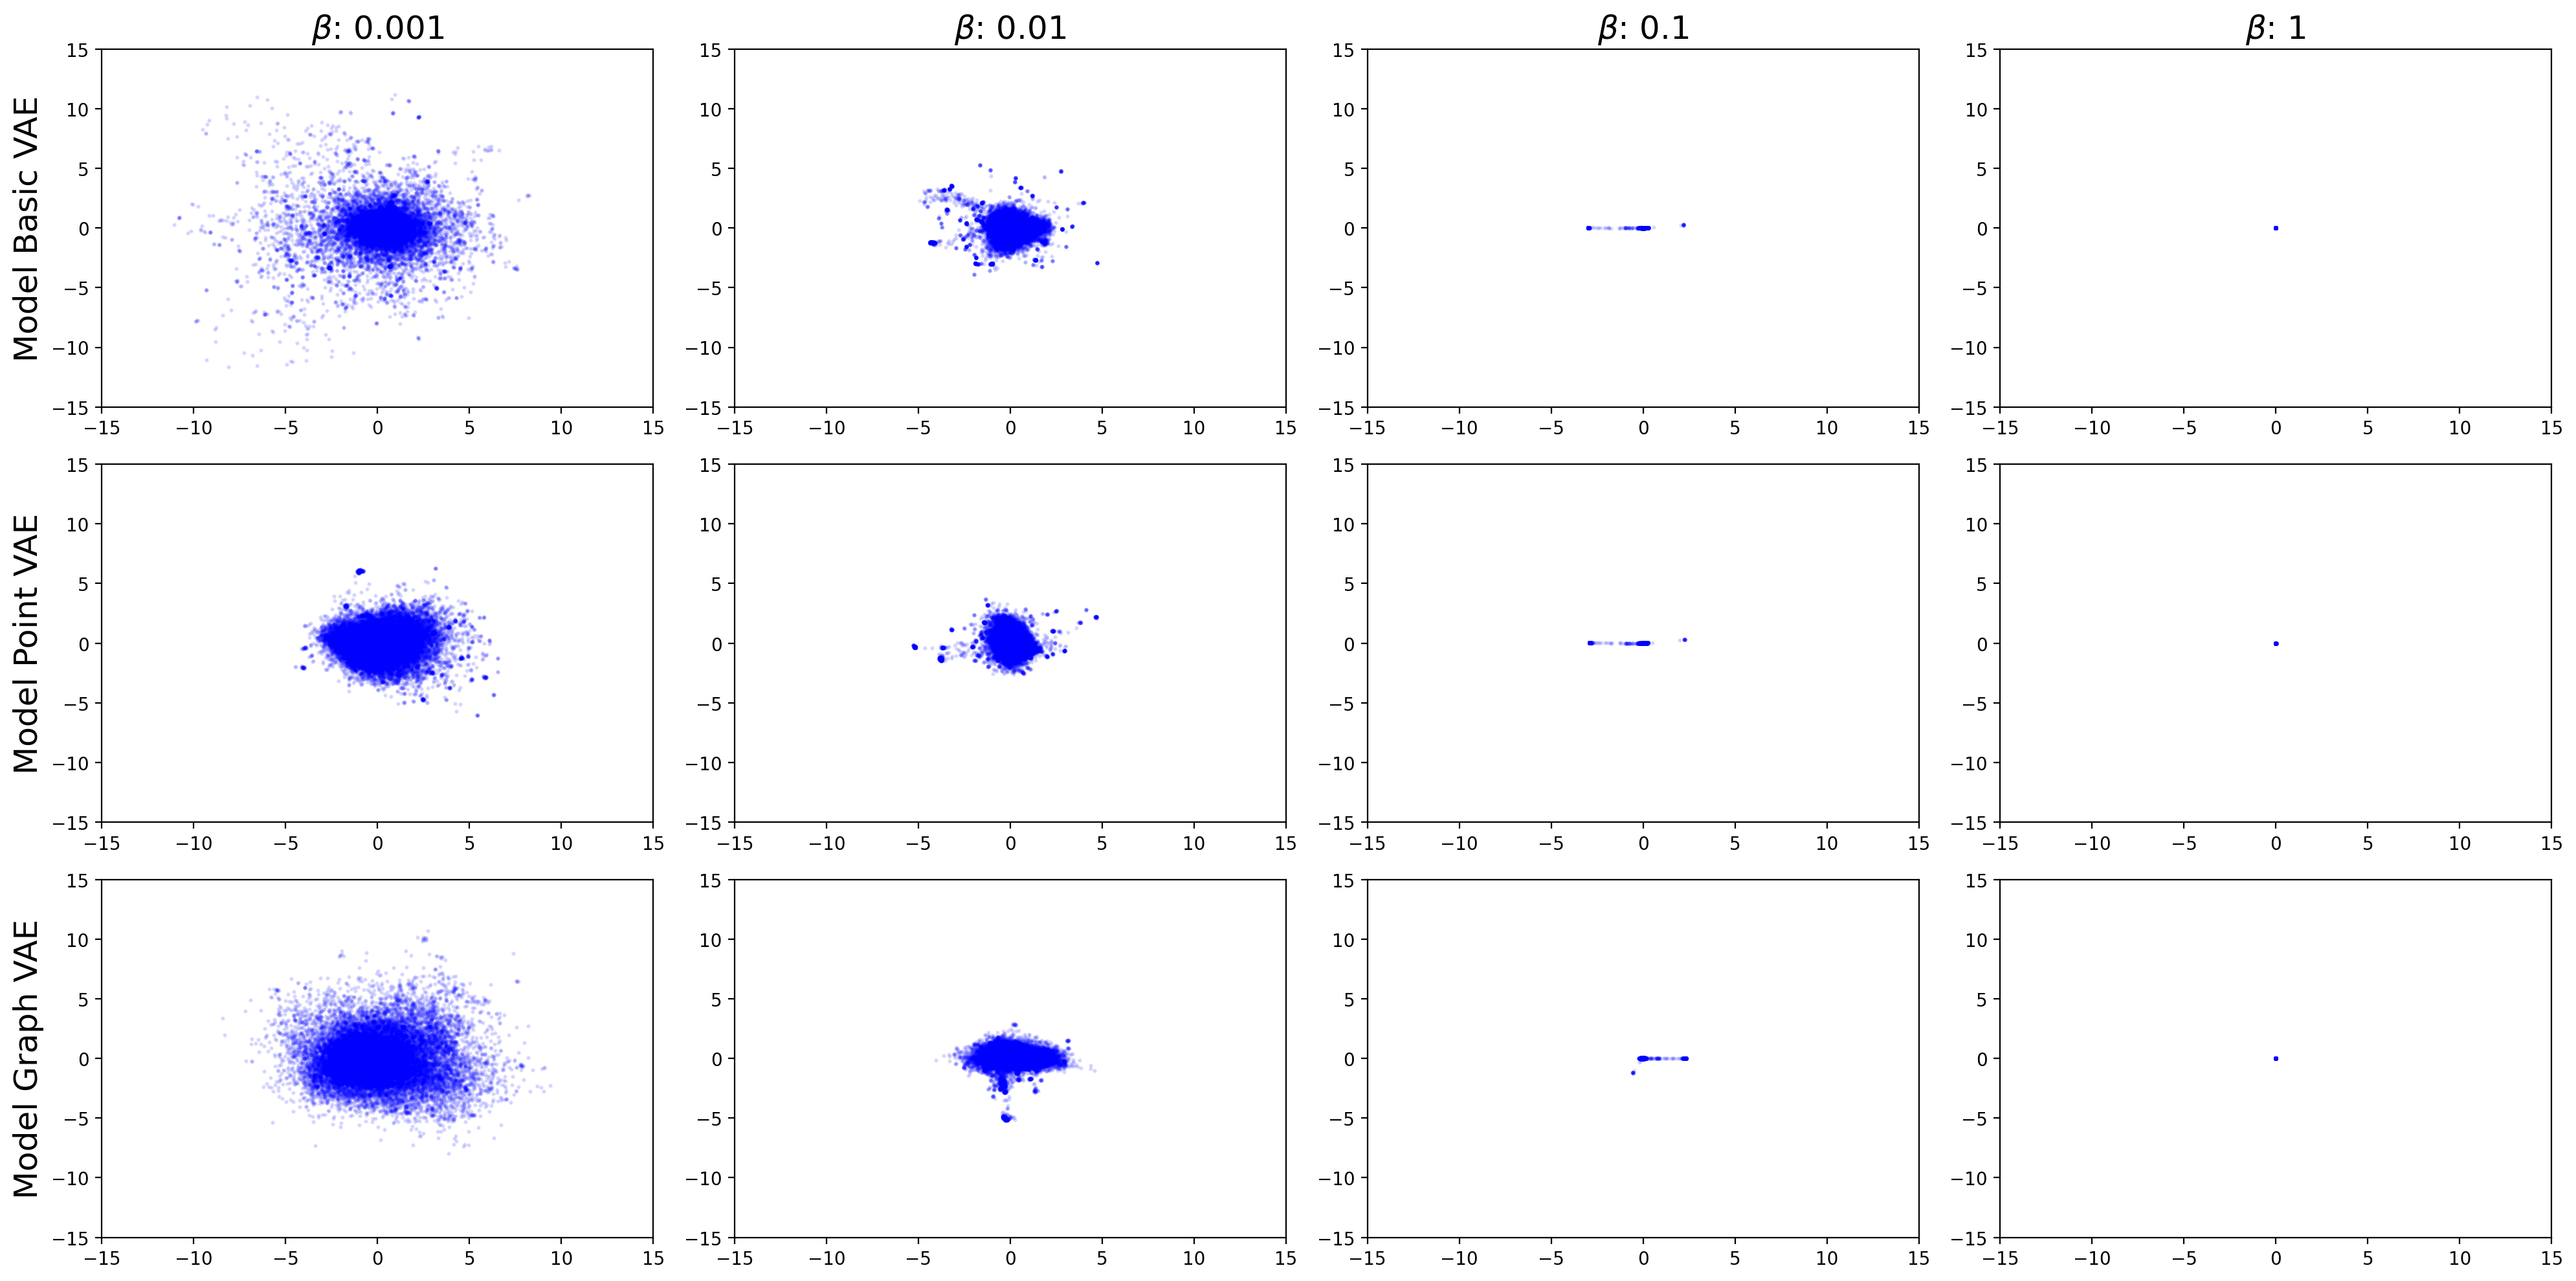

In [26]:
# CHANGE TO 3 BY 4 WHEN POINT DONE
fig, axes = plt.subplots(3,4, dpi = 200, figsize = (20,10))
models = ['Basic VAE', 'Point VAE', 'Graph VAE']
total_results = [basic_results, point_results, graph_results]
betas = [0.001,0.01,0.1,1]
for row, result in enumerate(total_results):
    for col, beta_result in enumerate(result):
        axes[row][col].scatter(beta_result[:,0], beta_result[:,1], s = 2, alpha = 0.1, color = 'b')


        axes[row][col].set_ylim(-15,15)
        axes[row][col].set_xlim(-15,15)

        if row == 0:
            axes[row][col].set_title(r'$\beta$: ' +f'{betas[col]}', size = 18)

        

    axes[row, 0].set_ylabel(f"Model {models[row]}", size = 18)
        

plt.tight_layout()